Convert a land cover raster to a shapefile, with attributes for fractional class coverage

TODO: 
* Add buffers to filter out disconnected littoral zones w no water nearby,
* Size filters
* ~~spatial join
* simplify polygons -or smooth
* double check number of unique polygons ----> debug
* ~~export to .shp
* save polygonization process as a function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage.measure import label, regionprops, regionprops_table
from skimage import measure
import rasterio as rio
from rasterio import plot, features
from rasterio.features import shapes
import shapely

%autosave 60 

Autosaving every 60 seconds


In [2]:
## user inputs
# classes={'wet': [1,2,3,4,5,11,13, 4], 'wet_emergent':[2,4,5,13], 'water': [1,3,11, 4]} # not used: water
classes={'wet': [1,2,3,4,5,11,13], 'wet_emergent':[2,5,13], 'water': [1,3,4,11]} # not used: water

In [3]:
# load using rasterio
landcover_in_path='/mnt/f/PAD2019/classification_training/PixelClassifier/Test35/padelE_36000_19059_003_190904_L090_CX_01_LUT-Freeman_cls.tif'
poly_out_pth='/mnt/f/PAD2019/classification_training/PixelClassifier/Test35/shp/padelE_36000_19059_003_190904_L090_CX_01_LUT-Freeman_cls_poly.shp'
bridges_pth='/mnt/f/PAD2019/classification_training/PixelClassifier/Test38/bridges/bridges.shp'
# segimg=glob.glob('Poly.tif')[0]
with rio.open(landcover_in_path) as src:
    lc = src.read(1)
lc.shape

(10299, 4776)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4776, 'height': 10299, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(6.276681000837538, 0.0, -888474.15962,
       0.0, -6.277291154481008, 2200084.8563), 'blockxsize': 480, 'blockysize': 1040, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


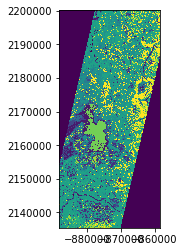

(6.276681000837538, 6.277291154481008)

In [4]:
# load srs for area math, etc
with rio.open(landcover_in_path) as src:
    src_crs=src.crs
    src_res=src.res
    src_shp=src.shape
    src=src
    print(src.profile)
    rio.plot.show(src)
src_res

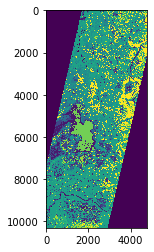

In [5]:
# reshape - not needed

    # these are unecessary thanks to src.read(1)
# lc=np.moveaxis(lc,[1, 2], [0,1])
# lc=lc[:,:,0]
lc.shape
plt.imshow(lc)



# Burn the bridges!

In [6]:
## burn in artificial bridges to separate open-basin lakes
bridges=gpd.read_file(bridges_pth)
bridges.head()
# dir(bridges.geometry)
# bridges.to_dict()

,Id,geometry
0,0,POLYGON ((-867364.1284027193 2185957.387243576...
1,0,POLYGON ((-882135.5013468508 2159387.351593679...
2,0,POLYGON ((-881933.8580171261 2157097.966474116...
3,0,POLYGON ((-874048.9557885099 2140747.585835955...
4,0,POLYGON ((-876548.0612440947 2139974.165919421...


In [7]:
# try 3 https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
bridges['val']=25 # add dummy variable
bridges.head()
bridges.val
shapes_gen = ((geom,value) for geom, value in zip(bridges.geometry, bridges.val))
bridges_burned = features.rasterize(shapes=shapes_gen, fill=0, out_shape=src.shape, transform=src.transform, all_touched=True)

In [8]:
# plt.imshow(bridges_burned)
(bridges_burned>0).sum() # sanity check

2240

In [9]:
# add burned bridges to original landcover raster
np.sum(lc==25)
lc[bridges_burned>0]=25
np.sum(lc==25)

2240

array([[  0,   0,   0, ..., 106, 106, 106],
       [  0,   0,   0, ..., 106, 106, 106],
       [  0,   0,   0, ..., 106, 106, 106],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

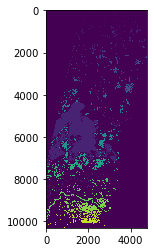

In [10]:
    # and convert to label matrix
lb=label(np.isin(lc, classes['wet']), connectivity=2)
plt.imshow(lb)
lb

In [11]:
## create masks
mask_wet_emerg = np.isin(lc, classes['wet_emergent'])
mask_wet = np.isin(lc, classes['wet'])
print(f'Number of masked pixels: {np.sum(mask_wet)}')

Number of masked pixels: 7783679


Use rasterio of Sean Gillies. It can be easily combined with Fiona (read and write shapefiles) and shapely of the same author.

In the script rasterio_polygonize.py the beginning is

In [29]:
%time
## convert to polygon #https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons
import pprint
# from rasterio.features import shapes
# with rio.drivers():
image =  lb.astype('float32') # src.read(1) # first band # np.isin(lc, classes['wet_emergent']).astype('float32')
results = (
{'properties': {'raster_val': v}, 'geometry': s}
for i, (s, v) 
in enumerate(
    shapes(image, mask=mask_wet, transform=src.transform, connectivity=8))) # transform=src.affine, mask=mask
pprint.pprint(next(results))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
{'geometry': {'coordinates': [[(-877502.521230536, 2200084.8563),
                               (-877502.521230536, 2200078.5790088456),
                               (-877496.2445495352, 2200078.5790088456),
                               (-877496.2445495352, 2200084.8563),
                               (-877502.521230536, 2200084.8563)]],
              'type': 'Polygon'},
 'properties': {'raster_val': 3.0}}


The result is a generator of GeoJSON features

In [30]:
geoms = list(results)
print(f'Number of polygons created: {len(geoms)}')
# print(next(results))

Number of polygons created: 42141


In [31]:
geoms[0]

{'properties': {'raster_val': 4.0},
 'geometry': {'type': 'Polygon',
  'coordinates': [[(-876736.7661484339, 2200084.8563),
    (-876736.7661484339, 2200072.301717691),
    (-876743.0428294347, 2200072.301717691),
    (-876743.0428294347, 2200066.0244265366),
    (-876736.7661484339, 2200066.0244265366),
    (-876730.4894674331, 2200066.0244265366),
    (-876730.4894674331, 2200084.8563),
    (-876736.7661484339, 2200084.8563)]]}}

That you can transform into shapely geometries

In [32]:
from shapely.geometry import shape
# shape(geoms[8]['geometry']) # outputs a box!
print(shape(geoms[7]['geometry']))
type(shape(geoms[7]['geometry']))
# print(geoms['geometry'][7:10])
# test_shape=shape(geoms['geometry'][7:10])
# type(test_shape)

POLYGON ((-873403.8485369891 2200084.8563, -873403.8485369891 2200078.579008846, -873391.2951749874 2200078.579008846, -873391.2951749874 2200084.8563, -873403.8485369891 2200084.8563))


shapely.geometry.polygon.Polygon

Create geopandas Dataframe and enable easy to use functionalities of spatial join, plotting, save as geojson, ESRI shapefile etc.

In [33]:
## convert to polygon

poly  = gpd.GeoDataFrame.from_features(geoms,crs=src_crs.wkt)
poly.head(20)


,geometry,raster_val
0,"POLYGON ((-876736.7661484339 2200084.8563, -87...",4.0
1,"POLYGON ((-876699.1060624288 2200084.8563, -87...",5.0
2,"POLYGON ((-876667.7226574246 2200084.8563, -87...",6.0
3,"POLYGON ((-875274.2994752387 2200084.8563, -87...",7.0
4,"POLYGON ((-875010.6788732036 2200084.8563, -87...",8.0
5,"POLYGON ((-873880.8762930528 2200084.8563, -87...",10.0
6,"POLYGON ((-873730.2359490327 2200084.8563, -87...",11.0
7,"POLYGON ((-873403.8485369891 2200084.8563, -87...",12.0
8,"POLYGON ((-872581.6033258794 2200084.8563, -87...",13.0
9,"POLYGON ((-872562.7732828769 2200084.8563, -87...",14.0


In [34]:
print(src.crs)

PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [35]:
poly.geometry[3]
poly[poly.raster_val==3.] # 3 is not there...

,geometry,raster_val


In [36]:
poly['label']=poly['raster_val'].astype(int) # for some reason, I had to create poly using double precesion? other int types?
del poly['raster_val']
poly.head()

,geometry,label
0,"POLYGON ((-876736.7661484339 2200084.8563, -87...",4
1,"POLYGON ((-876699.1060624288 2200084.8563, -87...",5
2,"POLYGON ((-876667.7226574246 2200084.8563, -87...",6
3,"POLYGON ((-875274.2994752387 2200084.8563, -87...",7
4,"POLYGON ((-875010.6788732036 2200084.8563, -87...",8


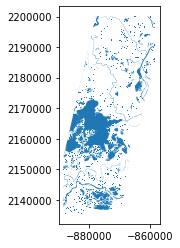

In [37]:
poly.plot()

# Regionprops

In [38]:
    # regionprops!
stats=measure.regionprops(lb, mask_wet_emerg, cache=True) # uses a mask of emergenet vegetation as intensity image, so mean_intensity gives percentage EV px
dir(stats[0])
stats[1001].mean_intensity


0.9259259259259259

In [39]:
## Display  regionprops calcs
pd.DataFrame(stats[100]).iloc[:,0]

0                            area
1                            bbox
2                       bbox_area
3                        centroid
4                     convex_area
5                    convex_image
6                          coords
7                    eccentricity
8             equivalent_diameter
9                    euler_number
10                         extent
11                    filled_area
12                   filled_image
13                          image
14                 inertia_tensor
15         inertia_tensor_eigvals
16                intensity_image
17                          label
18                 local_centroid
19              major_axis_length
20                  max_intensity
21                 mean_intensity
22                  min_intensity
23              minor_axis_length
24                        moments
25                moments_central
26                     moments_hu
27             moments_normalized
28                    orientation
29            

In [40]:
## re-compute as table (slower bc not lazy computation)
stats=measure.regionprops_table(lb, np.isin(lc, classes['wet_emergent']), cache=True, properties=['label','area','perimeter','mean_intensity']) # Users should remember to add "label" to keep track of region # cache is faster, but more mem identities.

In [41]:
## area math
stats=pd.DataFrame(stats)
stats.mean_intensity.max()
stats['em_fraction']=stats['mean_intensity']
del stats['mean_intensity']

stats['area_px_m2']=stats.area*np.prod(src_res)
stats['perimeter_px_m']=stats.perimeter*np.mean(src_res)
del stats['area']
del stats['perimeter']

stats

,label,em_fraction,area_px_m2,perimeter_px_m
0,1,0.118059,2.286099e+06,40315.958849
1,2,1.000000,3.546050e+02,37.661916
2,3,1.000000,3.940055e+01,0.000000
3,4,1.000000,1.576022e+02,20.130965
4,5,0.333333,1.182017e+02,6.276986
...,...,...,...,...
42137,42138,1.000000,7.880111e+01,0.000000
42138,42139,1.000000,7.880111e+01,0.000000
42139,42140,1.000000,7.880111e+01,0.000000
42140,42141,1.000000,3.940055e+01,0.000000


In [42]:
print(f'Label range: {lb.min()} : {lb.max()}')
print(f'Number of polygon geometries created: {len(geoms)}')
print(f'Number of polygons created: {len(poly)}') 

Label range: 0 : 42142
Number of polygon geometries created: 42141
Number of polygons created: 42141


In [43]:
## test to find unique vals

# len(poly)
# poly.iloc[:,1].unique().shape
# poly.shape
poly.label.max()
poly.label.unique().shape
d1=np.setdiff1d(poly.label.unique(), stats.label) # > Return the unique values in `ar1` that are not in `ar2`.
d2=np.setdiff1d(stats.label,poly.label.unique())
print(f'Number of polygons that aren\'t listed in regionprops: {d1.size}')
print(f'Number of regionprops regions that didn\'t become polygons: {d2.size}')
d2

Number of polygons that aren't listed in regionprops: 0
Number of regionprops regions that didn't become polygons: 1


array([3])

# Attribute join

In [44]:
poly.head()

,geometry,label
0,"POLYGON ((-876736.7661484339 2200084.8563, -87...",4
1,"POLYGON ((-876699.1060624288 2200084.8563, -87...",5
2,"POLYGON ((-876667.7226574246 2200084.8563, -87...",6
3,"POLYGON ((-875274.2994752387 2200084.8563, -87...",7
4,"POLYGON ((-875010.6788732036 2200084.8563, -87...",8


In [45]:
poly=poly.merge(stats, on='label') #country_shapes = country_shapes.merge(country_names, on='iso_a3')
poly.head()

,geometry,label,em_fraction,area_px_m2,perimeter_px_m
0,"POLYGON ((-876736.7661484339 2200084.8563, -87...",4,1.000000,157.602217,20.130965
1,"POLYGON ((-876699.1060624288 2200084.8563, -87...",5,0.333333,118.201662,6.276986
2,"POLYGON ((-876667.7226574246 2200084.8563, -87...",6,1.000000,157.602217,20.130965
3,"POLYGON ((-875274.2994752387 2200084.8563, -87...",7,1.000000,354.604987,47.838922
4,"POLYGON ((-875010.6788732036 2200084.8563, -87...",8,1.000000,512.207204,59.092887


In [46]:
# check if anything didn't merge
np.any(poly['em_fraction'].isnull())
# poly.head()
poly.crs

'PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'

# Simplify polygon - don't actually use this part

In [127]:
# poly_series=gpd.geoseries.GeoSeries(poly)
# gpd.GeoSeries(poly)

ValueError: Wrong number of items passed 2, placement implies 42142

In [30]:
poly_simpl=poly.simplify(tolerance=3, preserve_topology=True)

In [31]:
# poly_smooth1=poly.buffer(-2.).buffer(2.)

KeyboardInterrupt: 

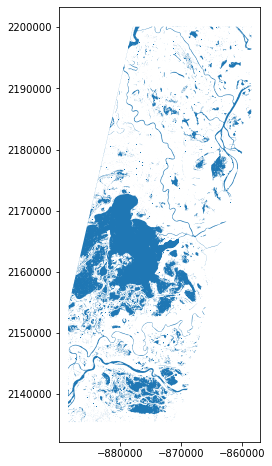

In [119]:
type(poly_simpl)
# poly_simpl.plot('em_fraction', legend=True, figsize=(8,8)) # only works for geodataframe, not geoseries
poly_simpl.plot(figsize=(8,8))

# save to .shp

In [47]:
# poly_simpl.to_file(poly_out_pth)
poly.to_file(poly_out_pth)

# Compute and plot statistics for EM

/home/ekyzivat/miniconda2/envs/geohack/lib/python3.7/site-packages/geopandas/geodataframe.py:471: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


Text(0.5, 0, 'EM fraction')

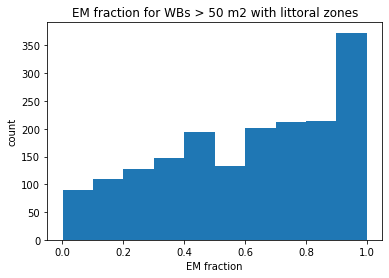

In [48]:
plt.hist(poly[poly.area_px_m2>50][poly.em_fraction<1][poly.em_fraction>0].em_fraction)
plt.title('EM fraction for WBs > 50 m2 with littoral zones')
plt.ylabel('count')
plt.xlabel('EM fraction')

# Unused scraps from trying to learn...

In [25]:
## print example output
next(results)

StopIteration: 

In [ ]:
with fiona.open(
        'test.shp', 'w',
        driver='Shapefile',
        crs=src.crs,
        schema={'properties': [('raster_val', 'int')],
        'geometry': 'Polygon'}) as dst:
    dst.writerecords(results)

In [14]:
#https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons
import fiona
from shapely.geometry import shape
import rasterio.features

mypoly=[]
for vec in rio.features.shapes(lb.astype('float32')):
    mypoly.append(shape(vec))

AttributeError: 'tuple' object has no attribute 'get'

In [ ]:
for vec, val in rio.features.shapes(lb.astype('float32')): # katia added val
    mypoly.append(shape(vec))

In [130]:
# scratch, making copies
dir(bridges)
bridges1=bridges.copy()
del bridges1['Id']
next(bridges1.iteritems())
# bridges.iterrows
bridges

,Id,geometry
0,0,POLYGON ((-867364.1284027193 2185957.387243576...
1,0,POLYGON ((-882135.5013468508 2159387.351593679...
2,0,POLYGON ((-881933.8580171261 2157097.966474116...
3,0,POLYGON ((-874048.9557885099 2140747.585835955...
4,0,POLYGON ((-876548.0612440947 2139974.165919421...
5,0,POLYGON ((-875307.1629289668 2140416.285553662...


In [85]:
from cartopy.feature import ShapelyFeature # https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
bridges_shapely=ShapelyFeature(bridges, src_crs)
print(bridges_shapely)

# Error
from shapely import wkt
wkt.dumps(bridges)